In [1]:
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

import sys
sys.path.append('..')

Plots ROC curves, precision recall curves, and helps find optimal thresholds.

In [2]:
case_metadata = pickle.load(open('../data/cases_211222_clean.pkl', 'rb'))
topic_metadata = pickle.load(open('../data/topics_211222_clean.pkl', 'rb'))

In [3]:
sent_results = pickle.load(open('../data/results/v3/sent_span_pred.pkl', 'rb'))
doc_results = pickle.load(open('../data/results/v3/doc_pred.pkl', 'rb'))
doc_score_dict: dict[int, dict[int, float]] = pickle.load(open('../data/results/1700656838/result_scores.pkl', 'rb'))
for case_id in [117, 183, 303]:
    # scored_docs = doc_results[case_id][~doc_results[case_id].pred_score.isna()]
    scored_docs = doc_results[case_id][~doc_results[case_id].pred_hf_bert.isna()]
    for doc_id in list(scored_docs.id_doc)[-3:]:
        print(doc_id)
        # print(f"{doc_score_dict[case_id][doc_id]:.3f} {doc_results[case_id][doc_results[case_id].id_doc == doc_id].iloc[0].pred_score:.3f}")
        print(f"{doc_score_dict[case_id][doc_id]:.3f} {doc_results[case_id][doc_results[case_id].id_doc == doc_id].iloc[0].pred_hf_bert:.3f}")
    print()

12216
0.992 1.000
7969
0.204 0.000
8206
0.001 0.000

8696
0.978 1.000
10552
0.143 0.000
11685
0.035 0.000

7969
0.185 0.000
7977
0.012 0.000
9068
0.020 0.000



In [4]:
sent_results = pickle.load(open('../data/results/v3/sent_span_pred.pkl', 'rb'))
doc_results = pickle.load(open('../data/results/v3/doc_pred.pkl', 'rb'))

# This is a one-time thing, but when we trained v3 models we didn't properly save the prediction scores
# for the entire document dataset, only for the fold (20%) being used for evaluation. We'd like to use 
# the entire dataset to help pick good thresholds, so we went back and did inference on the full thing,
# saving results in a dictionary which we can join to the original.
doc_score_dict: dict[int, dict[int, float]] = pickle.load(open('../data/results/1700656838/result_scores.pkl', 'rb'))
for case_id in doc_score_dict:
    for doc_id in doc_score_dict[case_id]:
        results_idx = doc_results[case_id][doc_results[case_id].id_doc == doc_id].iloc[0].name
        doc_results[case_id].at[results_idx, 'pred_score'] = doc_score_dict[case_id][doc_id]

# Random individual case to inspect
case_id = 117
case_doc_preds = doc_results[case_id]
# We only have sentence span dataset predictions for one fold (20% of the dataset)
case_sent_preds = sent_results[case_id][~sent_results[case_id].pred.isna()].copy()
case_sent_preds.info()
case_doc_preds.info()
print(case_doc_preds.label.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259 entries, 4 to 1560
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           259 non-null    object 
 1   source          259 non-null    object 
 2   status          24 non-null     object 
 3   service_id      259 non-null    int64  
 4   quoteText       24 non-null     object 
 5   case_id         259 non-null    int64  
 6   quoteStart      24 non-null     float64
 7   quoteEnd        24 non-null     float64
 8   document_id     259 non-null    int64  
 9   lang            259 non-null    object 
 10  sent_idx_start  259 non-null    Int64  
 11  sent_idx_end    259 non-null    Int64  
 12  num_sents       259 non-null    Int64  
 13  label           259 non-null    object 
 14  point_id        48 non-null     float64
 15  char_start      259 non-null    int64  
 16  char_end        259 non-null    int64  
 17  text            259 non-null    ob

[]

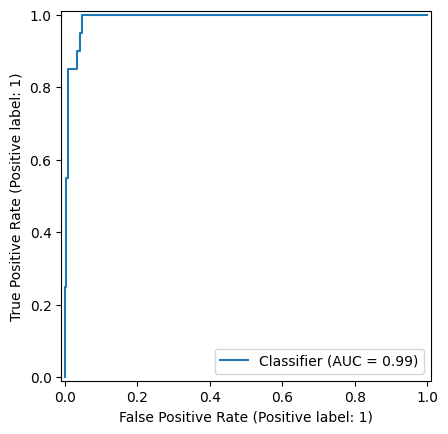

In [5]:
case_sent_preds.loc[:, 'int_labels'] = [0 if i == 'negative' else 1 for i in case_sent_preds.label]
RocCurveDisplay.from_predictions(case_sent_preds.int_labels, case_sent_preds.pred)
plt.plot()

[]

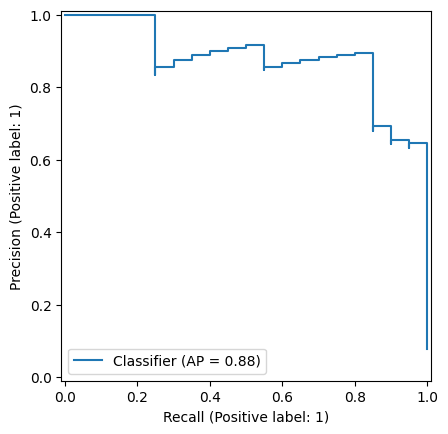

In [6]:
PrecisionRecallDisplay.from_predictions(case_sent_preds.int_labels, case_sent_preds.pred)
plt.plot()

Case 117
Threshold 0.608: 0.65 / 1.00 / 0.86
Threshold 0.679: 0.66 / 0.95 / 0.83
Threshold 0.864: 0.69 / 0.90 / 0.82
Threshold 0.976: 0.89 / 0.85 / 0.86 ***
Threshold 0.990: 0.92 / 0.55 / 0.63
Threshold 0.995: 1.00 / 0.25 / 0.33
Case 118
Threshold 0.998: 0.75 / 1.00 / 0.91 ***
Threshold 1.000: 0.83 / 0.83 / 0.83
Threshold 1.000: 1.00 / 0.67 / 0.74
Case 121
Threshold 0.000: 0.11 / 1.00 / 0.28
Threshold 0.000: 0.27 / 0.98 / 0.54
Threshold 0.004: 0.40 / 0.96 / 0.68
Threshold 0.005: 0.40 / 0.94 / 0.67
Threshold 0.008: 0.43 / 0.92 / 0.68
Threshold 0.011: 0.44 / 0.91 / 0.68
Threshold 0.026: 0.49 / 0.89 / 0.71 ***
Threshold 0.043: 0.51 / 0.83 / 0.70
Threshold 0.049: 0.52 / 0.81 / 0.69
Threshold 0.061: 0.53 / 0.79 / 0.69
Threshold 0.203: 0.59 / 0.77 / 0.70
Threshold 0.244: 0.59 / 0.75 / 0.69
Threshold 0.311: 0.60 / 0.72 / 0.68
Threshold 0.399: 0.65 / 0.70 / 0.68
Threshold 0.510: 0.71 / 0.68 / 0.69
Threshold 0.631: 0.74 / 0.66 / 0.68
Threshold 0.723: 0.76 / 0.64 / 0.67
Threshold 0.752: 0.76 / 0

/var/folders/l5/210k0yvw8xj04j001s6yhlr00000gq/T/ipykernel_92597/393037300.py:2: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


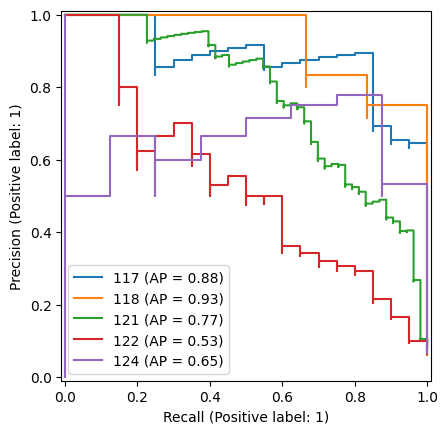

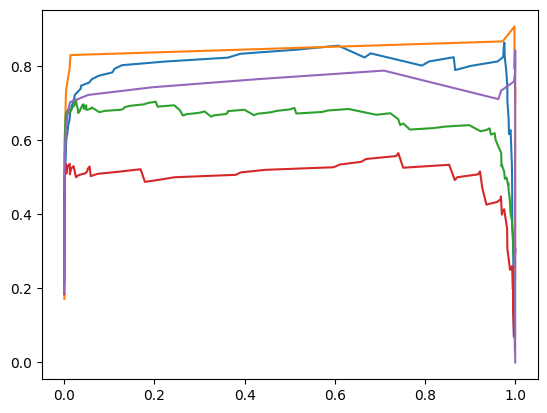

In [7]:
from scipy.signal import argrelextrema
from scipy.ndimage.filters import uniform_filter1d

def plot_cases(case_ids, docs=True):
    fig, ax = plt.subplots()
    fig2, ax2 = plt.subplots()

    for case_id in case_ids:
        if docs:
            preds = doc_results[case_id][~doc_results[case_id].pred_score.isna()].copy()
            preds['pred'] = preds['pred_score']
        else:
            preds = sent_results[case_id][~sent_results[case_id].pred.isna()].copy()
        preds.loc[:, 'int_labels'] = [0 if i == 'negative' else 1 for i in preds.label]

        p, r, thresholds = precision_recall_curve(preds.int_labels, preds.pred)
        PrecisionRecallDisplay.from_predictions(preds.int_labels, preds.pred, ax=ax, name=case_id)

        # Dynamic thresholds, locally maximize fscore
        # Recall is more important than precision; if curators are shown bad predictions that's ok
        fscore_beta = 1.5
        # Hacky protection against divide by zero, when precision and recall are zero
        for i in range(len(p)):
            if p[i] == 0 and r[i] == 0:
                p[i] = -1
        fscore_curve = ((1 + np.square(fscore_beta)) * (p * r) / ((p * np.square(fscore_beta)) + r))[:-1]
        ax2.plot(thresholds, fscore_curve)
        print(f"Case {case_id}")
        # Doc dataset threshold curves are not smooth enough and have too many local maxes
        if docs:
            fscore_curve = uniform_filter1d(fscore_curve, 5)
        for local_max in argrelextrema(fscore_curve, np.greater)[0]:
            biggest_str = ' ***' if local_max == np.argmax(fscore_curve) else ''
            print(f"Threshold {thresholds[local_max]:.3f}: {p[local_max]:.2f} / {r[local_max]:.2f} / {fscore_curve[local_max]:.2f}{biggest_str}")

    plt.plot()

plot_cases(list(sent_results.keys())[:5], False)

Case 117
Threshold 0.943: 0.79 / 0.98 / 0.92 ***
Case 118
Threshold 1.000: 0.72 / 0.96 / 0.87 ***
Threshold 1.000: 0.81 / 0.85 / 0.83
Case 121
Threshold 0.469: 0.43 / 0.98 / 0.70
Threshold 0.477: 0.43 / 0.98 / 0.70
Threshold 0.780: 0.46 / 0.96 / 0.72
Threshold 0.823: 0.47 / 0.95 / 0.72
Threshold 0.836: 0.47 / 0.94 / 0.72
Threshold 0.867: 0.48 / 0.94 / 0.72
Threshold 0.877: 0.48 / 0.94 / 0.72
Threshold 0.892: 0.49 / 0.93 / 0.73
Threshold 0.919: 0.50 / 0.91 / 0.73 ***
Threshold 0.939: 0.51 / 0.89 / 0.72
Threshold 0.958: 0.52 / 0.87 / 0.72
Threshold 0.962: 0.53 / 0.86 / 0.72
Threshold 0.964: 0.53 / 0.85 / 0.72
Threshold 0.971: 0.53 / 0.83 / 0.71
Threshold 0.974: 0.54 / 0.82 / 0.71
Threshold 0.978: 0.55 / 0.81 / 0.71
Threshold 0.982: 0.56 / 0.79 / 0.70
Threshold 0.985: 0.57 / 0.76 / 0.69
Threshold 0.989: 0.57 / 0.70 / 0.66
Threshold 0.990: 0.57 / 0.68 / 0.65
Threshold 0.991: 0.60 / 0.67 / 0.65
Threshold 0.992: 0.61 / 0.67 / 0.65
Threshold 0.994: 0.62 / 0.60 / 0.60
Threshold 0.994: 0.64 / 0

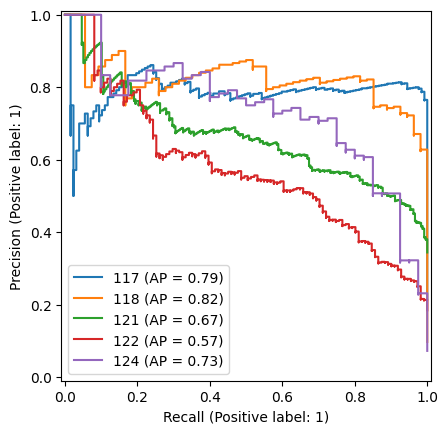

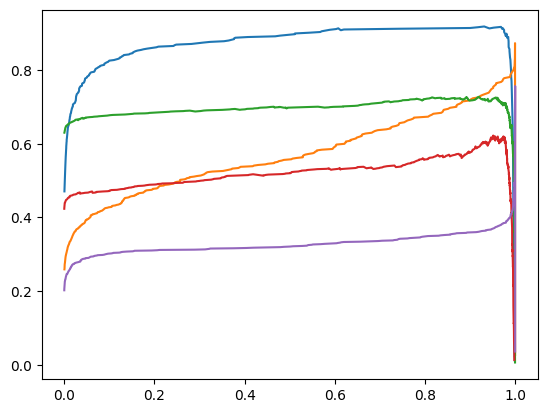

In [8]:
plot_cases(list(sent_results.keys())[:5], True)

Case 199
Threshold 0.070: 0.09 / 1.00 / 0.25
Threshold 0.177: 0.13 / 0.98 / 0.33
Threshold 0.264: 0.16 / 0.95 / 0.37
Threshold 0.300: 0.16 / 0.93 / 0.38
Threshold 0.371: 0.18 / 0.89 / 0.40
Threshold 0.423: 0.19 / 0.84 / 0.41
Threshold 0.505: 0.21 / 0.82 / 0.43 ***
Threshold 0.539: 0.20 / 0.77 / 0.41
Threshold 0.585: 0.21 / 0.73 / 0.41
Threshold 0.658: 0.20 / 0.64 / 0.38
Threshold 0.681: 0.20 / 0.59 / 0.37
Threshold 0.766: 0.21 / 0.55 / 0.37
Threshold 0.785: 0.22 / 0.52 / 0.36
Threshold 0.844: 0.26 / 0.50 / 0.39
Threshold 0.869: 0.28 / 0.48 / 0.39
Threshold 0.916: 0.32 / 0.43 / 0.39
Threshold 0.954: 0.39 / 0.36 / 0.37
Threshold 0.961: 0.50 / 0.34 / 0.38
Case 201
Threshold 0.081: 0.57 / 1.00 / 0.81
Threshold 0.210: 0.68 / 0.97 / 0.86 ***
Threshold 0.241: 0.69 / 0.96 / 0.86
Threshold 0.253: 0.69 / 0.95 / 0.86
Threshold 0.264: 0.69 / 0.95 / 0.85
Threshold 0.331: 0.71 / 0.93 / 0.85
Threshold 0.362: 0.72 / 0.92 / 0.85
Threshold 0.515: 0.73 / 0.84 / 0.80
Threshold 0.554: 0.74 / 0.82 / 0.80
Th

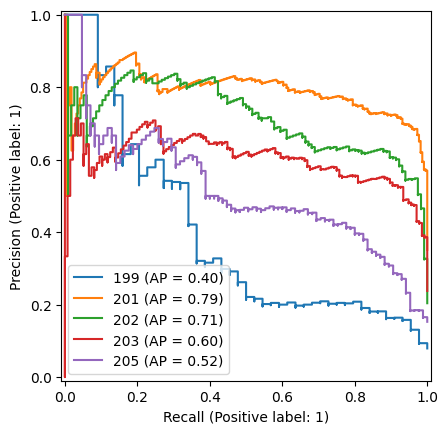

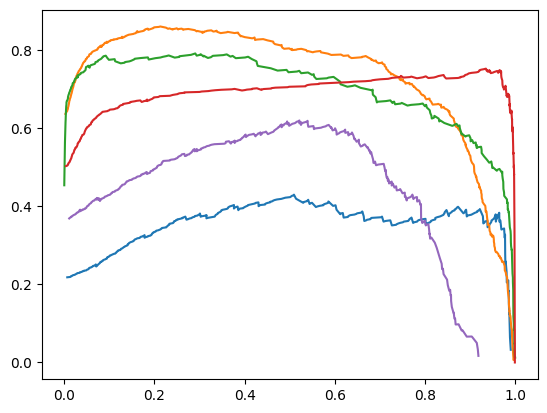

In [9]:
plot_cases(list(sent_results.keys())[40:45], True)

Case 279
Threshold 0.820: 0.24 / 1.00 / 0.51
Threshold 0.932: 0.26 / 0.99 / 0.53
Threshold 0.967: 0.28 / 0.98 / 0.55
Threshold 0.976: 0.29 / 0.97 / 0.56
Threshold 0.980: 0.29 / 0.94 / 0.56
Threshold 0.986: 0.30 / 0.93 / 0.57
Threshold 0.988: 0.30 / 0.92 / 0.57
Threshold 0.990: 0.31 / 0.91 / 0.57
Threshold 0.991: 0.31 / 0.90 / 0.57
Threshold 0.993: 0.32 / 0.89 / 0.57 ***
Threshold 0.996: 0.32 / 0.84 / 0.56
Threshold 0.997: 0.33 / 0.83 / 0.56
Threshold 0.997: 0.33 / 0.82 / 0.57
Threshold 0.998: 0.34 / 0.77 / 0.55
Threshold 0.999: 0.35 / 0.72 / 0.54
Threshold 0.999: 0.36 / 0.70 / 0.54
Threshold 0.999: 0.36 / 0.66 / 0.52
Threshold 0.999: 0.37 / 0.63 / 0.52
Threshold 1.000: 0.37 / 0.50 / 0.45
Threshold 1.000: 0.39 / 0.44 / 0.43
Threshold 1.000: 0.41 / 0.43 / 0.43
Threshold 1.000: 0.43 / 0.42 / 0.43
Threshold 1.000: 0.37 / 0.24 / 0.27
Threshold 1.000: 0.39 / 0.20 / 0.24
Threshold 1.000: 0.25 / 0.01 / 0.02
Case 280
Threshold 0.012: 0.29 / 1.00 / 0.57
Threshold 0.020: 0.31 / 0.99 / 0.59
Thresh

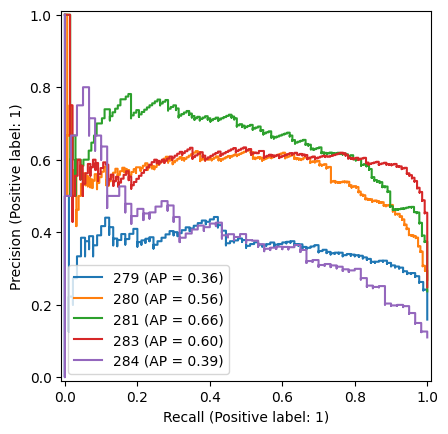

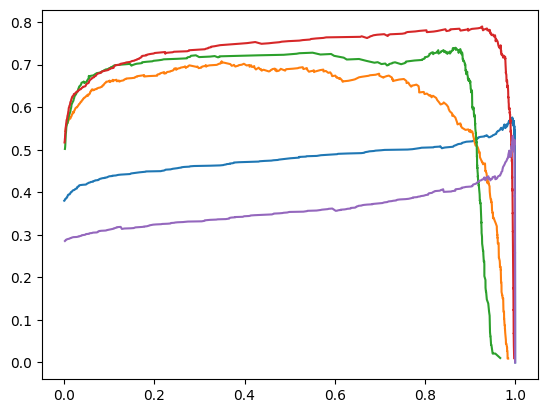

In [10]:
plot_cases(list(sent_results.keys())[70:75], True)

In [6]:
fscore_beta = 1.5
case_metrics = []
for case_id in doc_results:
    case_doc_preds = doc_results[case_id][~doc_results[case_id].pred_score.isna()].copy()
    case_doc_preds.loc[:, 'int_labels'] = [0 if i == 'negative' else 1 for i in case_doc_preds.label]

    p, r, thresholds = precision_recall_curve(case_doc_preds.int_labels, case_doc_preds.pred_score)
    # Hacky protection against divide by zero, when precision and recall are zero
    for i in range(len(p)):
        if p[i] == 0 and r[i] == 0:
            p[i] = -1
    fscore_curve = ((1 + np.square(fscore_beta)) * (p * r) / ((p * np.square(fscore_beta)) + r))[:-1]
    optimal_idx = np.argmax(fscore_curve)
    case_metrics.append({
        'case_id': case_id,
        'threshold': thresholds[optimal_idx],
        'prec': p[optimal_idx],
        'rec': r[optimal_idx],
        'fscore': fscore_curve[optimal_idx],
        'title': case_metadata.loc[case_id].title,
        'topic': topic_metadata.loc[case_metadata.loc[case_id].topic_id].title
    })
case_metrics = pd.DataFrame(case_metrics)
case_metrics

,case_id,threshold,prec,rec,fscore,title,topic
0,117,0.931303,0.787500,0.992126,0.918676,You waive your right to a class action.,Dispute Resolution
1,118,0.999651,0.722222,0.962963,0.873385,You waive your moral rights,Ownership
2,121,0.919458,0.501166,0.911017,0.727865,Terms may be changed any time at their discre...,Notice of Changing Terms
3,122,0.951238,0.413953,0.801802,0.622378,"The terms may be changed at any time, but you ...",Notice of Changing Terms
4,124,0.999946,0.607143,0.850000,0.756849,When the service wants to make a material chan...,Notice of Changing Terms
...,...,...,...,...,...,...,...
118,403,0.966409,0.380952,0.975610,0.659062,"Instead of asking directly, this Service will ...",Notice of Changing Terms
119,481,0.887309,0.519824,0.967213,0.764706,The service claims to be GDPR compliant for Eu...,Jurisdiction and governing laws
120,482,0.996205,0.438462,0.890625,0.676095,The service claims to be CCPA compliant for Ca...,Jurisdiction and governing laws
121,484,0.972351,0.503067,0.901099,0.724677,You must report to the service any unauthorize...,Security


          case_id   threshold        prec         rec      fscore
count  123.000000  123.000000  123.000000  123.000000  123.000000
mean   249.731707    0.792605    0.523050    0.863314    0.709260
std     90.090489    0.257060    0.141128    0.114392    0.125587
min    117.000000    0.054856    0.154639    0.341463    0.327731
25%    180.000000    0.663508    0.414294    0.803090    0.628040
50%    230.000000    0.931303    0.519824    0.895238    0.718276
75%    306.500000    0.992675    0.618371    0.949480    0.803645
max    486.000000    0.999965    0.857798    1.000000    0.941518


(array([ 2.,  4.,  5.,  5.,  9.,  4.,  7.,  9., 10., 68.]),
 array([0.05485598, 0.14936684, 0.24387771, 0.33838857, 0.43289943,
        0.52741029, 0.62192115, 0.71643201, 0.81094287, 0.90545373,
        0.99996459]),
 <BarContainer object of 10 artists>)

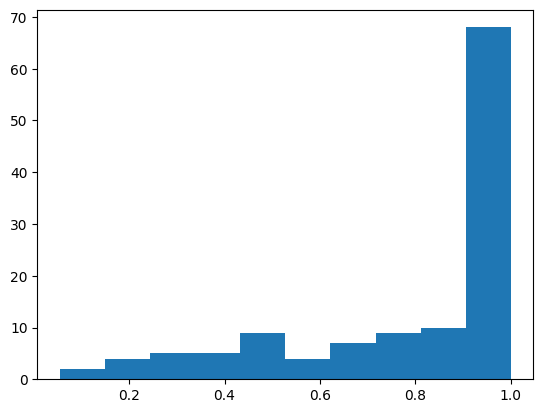

In [12]:
print(case_metrics.describe())
plt.hist(case_metrics.threshold)

(array([ 2.,  2.,  4., 10., 16., 23., 18., 22., 21.,  5.]),
 array([0.32773109, 0.3891098 , 0.45048851, 0.51186723, 0.57324594,
        0.63462465, 0.69600336, 0.75738207, 0.81876078, 0.88013949,
        0.9415182 ]),
 <BarContainer object of 10 artists>)

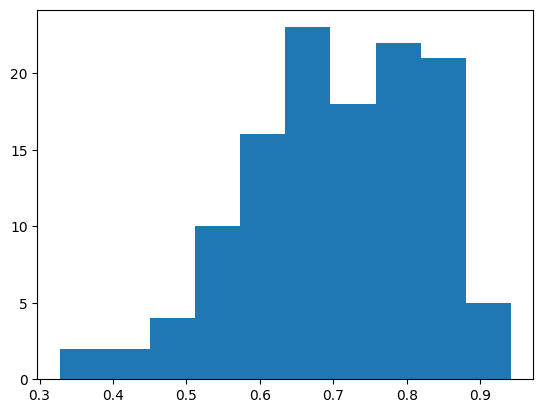

In [13]:
plt.hist(case_metrics.fscore)

In [14]:
case_metrics.sort_values('fscore').head(15)

,case_id,threshold,prec,rec,fscore,title,topic
63,232,0.999718,0.154639,0.652174,0.327731,A free help desk is provided,Transparency
30,178,0.939058,0.424242,0.341463,0.363273,Logs are kept for an undefined period of time,Logs
40,199,0.509346,0.208092,0.818182,0.430147,The terms for this service are easy to read,Transparency
60,229,0.992010,0.264957,0.632653,0.443344,You cannot distribute or disclose your account...,Transparency
65,239,0.862240,0.379310,0.500000,0.455414,Private messages can be read,Personal Data
89,300,0.672249,0.359712,0.543478,0.469653,A complaint mechanism is provided for the hand...,Personal Data
6,127,0.315974,0.320388,0.660000,0.497680,"Third party cookies are employed, but with opt...",Trackers
69,278,0.992472,0.273859,0.825000,0.509501,The service is not responsible for linked or (...,Guarantee
94,311,0.694745,0.342342,0.690909,0.526092,Your personal data is not shared with third pa...,Third Parties
122,486,0.994242,0.277027,0.891304,0.529821,Minors must have the authorization of their le...,Governance


<AxesSubplot:xlabel='prec', ylabel='rec'>

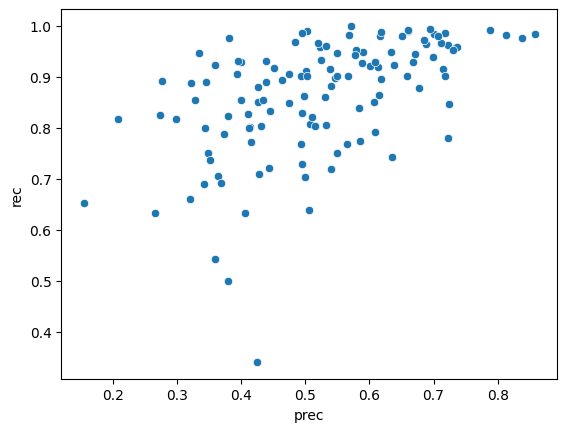

In [15]:
sns.scatterplot(case_metrics, x='prec', y='rec')

In [8]:
case_metrics.set_index('case_id', drop=True).threshold.to_dict()

{117: 0.9313029646873474,
 118: 0.9996505975723267,
 121: 0.9194583892822266,
 122: 0.9512377381324768,
 124: 0.999946117401123,
 126: 0.8929231762886047,
 127: 0.31597447395324707,
 128: 0.8838386535644531,
 129: 0.9749407768249512,
 130: 0.9065191149711609,
 134: 0.7489349842071533,
 138: 0.8780727386474609,
 139: 0.9998829364776611,
 140: 0.9612037539482117,
 143: 0.9117705225944519,
 145: 0.9865456819534302,
 146: 0.06113763153553009,
 147: 0.9860677123069763,
 148: 0.9632765650749207,
 149: 0.9952959418296814,
 150: 0.9619890451431274,
 151: 0.9394944906234741,
 152: 0.5705567002296448,
 162: 0.9346338510513306,
 163: 0.31521105766296387,
 164: 0.404929518699646,
 166: 0.4554845690727234,
 170: 0.690903902053833,
 175: 0.9982500672340393,
 177: 0.979971706867218,
 178: 0.939058244228363,
 182: 0.9997735619544983,
 183: 0.9350226521492004,
 187: 0.7722886800765991,
 188: 0.2906496822834015,
 190: 0.4945354163646698,
 193: 0.9803260564804077,
 195: 0.9073813557624817,
 196: 0.998818

In [10]:
# Save metadata of trained models to a spreadsheet
case_metadata = pd.read_pickle('../data/cases_211222_clean.pkl')
topic_metadata = pd.read_pickle('../data/topics_211222_clean.pkl')
cases = pd.merge(case_metadata, case_metrics, left_index=True, right_on='case_id')
cases = pd.merge(cases, topic_metadata, left_on='topic_id', right_index=True)
cases['fscore'] = cases.fscore.round(3)
for attr in ['id', 'title', 'description']:
    cases[attr] = cases[f'{attr}_x']
cases.sort_values('id')[['id', 'classification', 'score', 'fscore', 'title', 'description']].to_csv('case_models.csv', index=False)